# DATA SCI 401: LIGO Problem Set 2

**Detailed updated version by Z Doctor, Apr 2022**

Earlier version by Chris Pankow

This problem set introduces the matched filter, one of the key tools used in gravitaitonal wave astronomy.

For more background, you may like to read though Chapter 7 of [Gravitational Waves: Volume 1](https://www.oxfordscholarship.com/view/10.1093/acprof:oso/9780198570745.001.0001/acprof-9780198570745), particular Sections 7.1 and 7.3. You should be able to access the online version of this book through the Northwestern library.

You will need FFTs and inververse FFTs for these problems. `numpy` can be used for this.

You will also be dealing with multiple noise curves, multiple data streams, and multiple templates. It is recommended to put all e.g. noise curves into a single dictionary or array, and similarly with the data and templates. This way you can easily loop over these later

## Problem 1

Use the Hanford and Livingston amplitude spectral densities (ASD) data files (`H1-ASD.txt`, `L1-ASD.txt`) and calculate the power spectral densities (PSDs) $S_n(f)$. Plot the PSDs for Hanford and Livingston. _hint: the PSD is just the square of the ASD_

In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('dark_background')

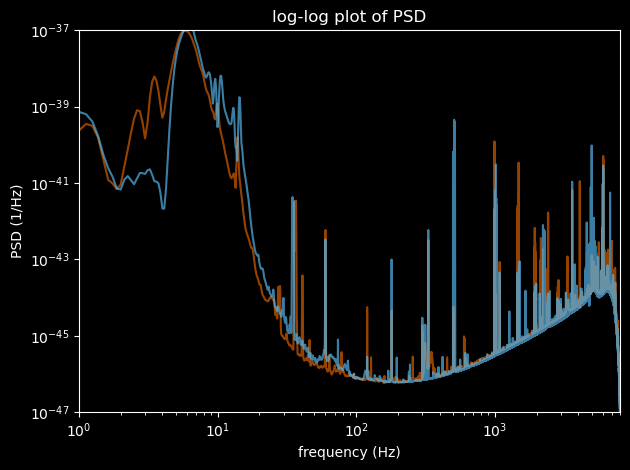

In [4]:
basedir = 'DATA_SCI_401_LIGO-2'
ASD_files = {'H1':'H1-ASD.txt',
             'L1':'L1-ASD.txt'}

color_labels = {'H1':'#D55E00', 'L1':'#56B4E9'}

ax = plt.gca()
ASDs = dict()
for key, ASD_file in ASD_files.items():
    data = np.genfromtxt(f'{basedir}/{ASD_file}',names=True)
    ASDs[key] = data
    ax.loglog(data['frequencyHz'],data['ASDHz05']**2,alpha=0.7, color=color_labels[key])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD (1/Hz)')
ax.set_title('log-log plot of PSD')
ax.set_ylim([1e-47, 1e-37])
ax.set_xlim([1e0, 8e3])

plt.tight_layout()

Comment on where the detectors are most sensitive

**Answer**: 

These ASDs have been calculated from data sampled in the time domain. Given the maximum frequency of the ASDs, what is the minimum sampling rate for the time domain data? Explain why.

In [6]:
# max frequency of PSD:

**Answer**:

*Hint*: You can find the actual sampling rate in the [GWOSC Open Data paper](https://arxiv.org/abs/1912.11716). 

## Problem 2

Three 600-second noisy datastreams $s(t)$ for the Hanford and Livingston detectors have been provided: `*1-a.txt`, `*1-b.txt` and `*1-c.txt`, where `*` is `H` for Hanford and `L` for Livingston.

The noise in these datastreams can be assumed to be realizations from the PSDs in Problem 1. The three datastreams may each have compact binary coalescence *signals* embedded within them. Plot the data. 

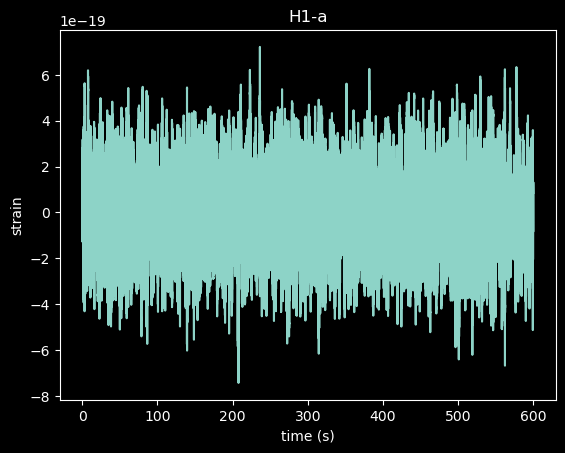

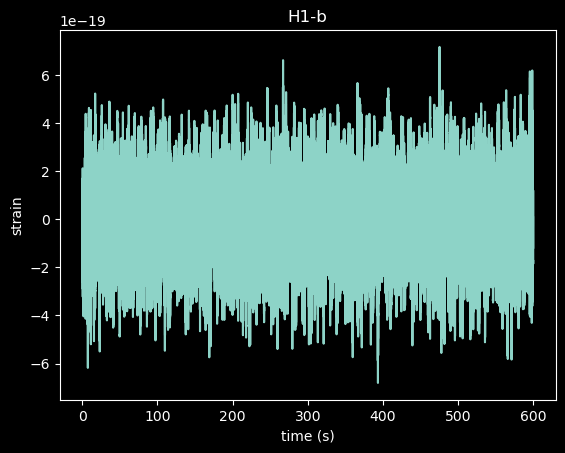

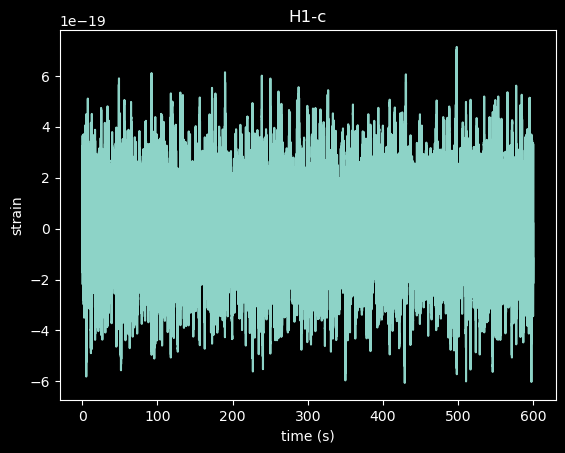

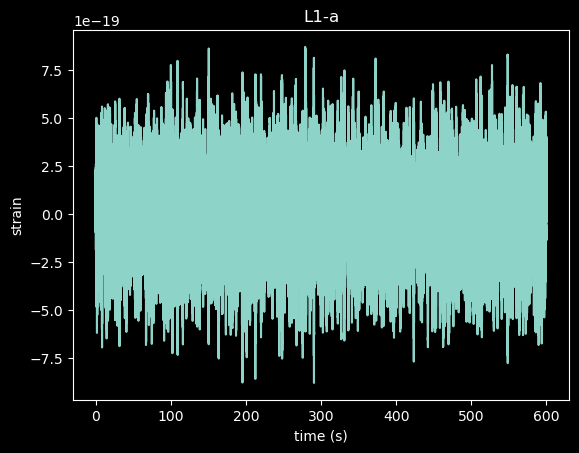

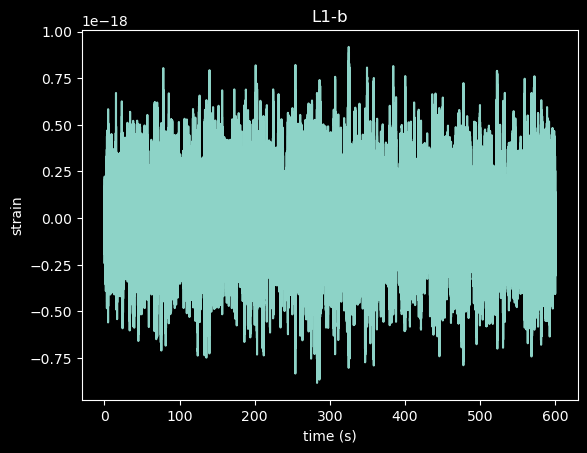

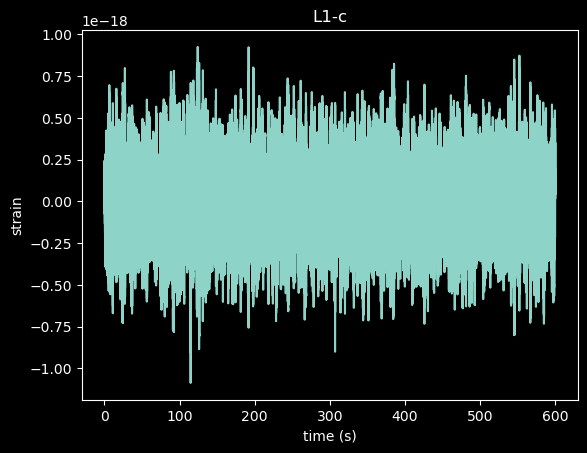

In [5]:
## plot data here
strain_data = {}
for key in list(ASDs.keys()):
    for label in ['a','b','c']:
        strain_data[f'{key}-{label}'] = np.genfromtxt(f'{basedir}/{key}-{label}.txt',names=True)
        plt.figure()
        plt.plot(strain_data[f'{key}-{label}']['times'],strain_data[f'{key}-{label}']['strain'])
        plt.xlabel('time (s)');
        plt.ylabel('strain');
        plt.title(f'{key}-{label}')

Can you identify the presence of the signals by eye?

**Answer**: 

## Problem 3

You are also provided three waveforms for a binary black hole, neutron star black hole, and binary neutron star coalescence: `bbh-waveform.txt`, `nsbh-waveform.txt` and `bns-waveform.txt` respectively. Using these templates with each datastream, you will calculate and plot the matched-filtering SNR as a function of the time shift between the various templates $h(t)$ and the data $s(t)$. 

For this, you will need to Fourier transform both the template and the data. Do not worry about normalising your Fourier transforms (unless you really want to), as we are only interested in qualitative results.

This problem will take you through the SNR calculations step by step

### Problem 3a
Plot the three templates. 

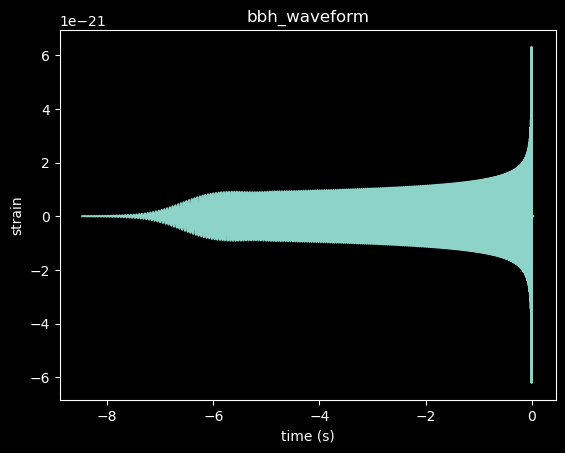

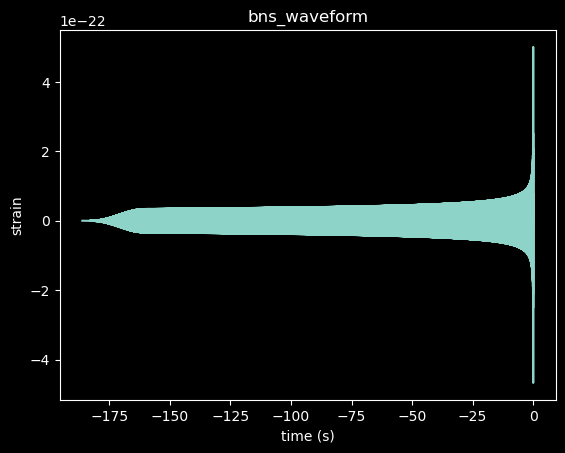

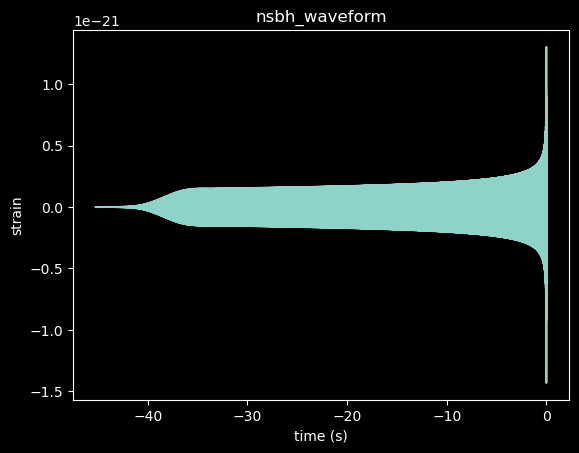

In [10]:
## plot the templates

waveform_files = {'bbh_waveform':'bbh_waveform.txt', 'bns_waveform':'bns_waveform.txt', 'nsbh_waveform':'nsbh_waveform.txt'}

color_labels = {'bbh_waveform':'#D55E00', 'bns_waveform':'#56B4E9', 'nsbh_waveform':'#E6DAA6'}

waveforms = dict()
for key, waveform_file in waveform_files.items():
    data = np.genfromtxt(f'{basedir}/{waveform_file}',names=True)
    waveforms[key] = data

waveform_strain_data = {}
for key in list(waveforms.keys()):
    waveform_strain_data[f'{key}'] = np.genfromtxt(f'{basedir}/{key}.txt',names=True)
    plt.figure()
    plt.plot(waveform_strain_data[f'{key}']['times'],waveform_strain_data[f'{key}']['strain'])
    plt.xlabel('time (s)');
    plt.ylabel('strain');
    plt.title(f'{key}')

What do you primarily notice is the difference between them?

### Problem 3b: Computing whitened strains in the frequency domain

**Remembering the definition of SNR**

Recall that the matched filter SNR is
$$S/N = \frac{\langle u | h \rangle}{\langle u | u \rangle^{1/2}}$$
Where $u$ is the filter. The SNR is maximized when $u\propto h$ as we learned in class. Let's unpack the terms. First recall that the inner product we defined is:
$$\langle a | b \rangle = 4{\rm Re}\int_0^\infty \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)}df$$
Where the $\sim$ symbol denotes the fourier transform.
Since we don't know exactly when the signal occurs in the data, $u$ is a function of the relative time lag $\tau$ between the start of the data and the start of the template. Therefore, the SNR is also a function of $\tau$. Thankfully, we can make use of some Fourier theory to make it easy to find the time lag of the matched filter!

**Getting the SNR time series**

Recall that if the Fourier transform $\mathcal{F}[u(\tau=0)] = \tilde{u}(f)$ then $\mathcal{F}[u(\tau)] = \tilde{u}(f)e^{2\pi i f\tau}$. Let's plug this into the numerator term of our SNR expression:
$$ \langle u(\tau) | h \rangle  = 4{\rm Re}\int_0^\infty \frac{\tilde{u}(f)\tilde{h}^*(f)e^{2\pi i f\tau}}{S_n(f)}df = 4{\rm Re}\int_0^\infty \frac{\tilde{u}(f)}{S_n(f)^{1/2}}\frac{\tilde{h}^*(f)}{S_n(f)^{1/2}}e^{2\pi i f\tau}df = 4{\rm Re}\int_0^\infty \tilde{u}_{w}(f)\tilde{h}_w^*(f)e^{2\pi i f\tau}df$$
Here we've defined $\tilde{u}_{w}(f) = \frac{\tilde{u}(f)}{S_n(f)^{1/2}}$ and similarly for $\tilde{h}_w$. The $w$ subscripts denoted the *whitened* frequencies series. Whitening just means dividing out the amplitude spectral density of the noise, which upweights (downweights) the signal at frequencies at which there is low (high) noise. You'll also note that this integral above is just the inverse Fourier transform of $\tilde{u}_{w}(f)\tilde{h}_w^*(f)$! So all we need to do to get the numerator term as a function of $\tau$ is calculate the whitened frequency series for both the template and the data, multiply them, and then take the inverse Fourier transform. What we'll be left with is the complex SNR time series. We can take the absolute value of this to get the SNR vs time lag.

As a first step, create a function to calculate the whitened frequency domain strains. To do FFTs, you'll use the [`numpy.fft.rfft`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft.html) function, which produces the "right-handed" FFT, i.e. it only includes the (complex) amplitudes for *positive* frequencies. The regular FFT will give you amplitudes for both positive and negative frequencies, but when you take the FFT of a real signal the amplitudes at positive and negative frequencies are the same up to a complex conjugate. Long story short, we're dealing with real-valued time series, so we only need right handed FFTs. 

*Hint*: use `np.interp` to interpolate the ASD to the frequencies defined by the FFT of your strain time series so you can divide out the ASD at the end.

In [10]:
def get_whitened_frequency_series(strain, times, ASD, ASD_freqs):
    """
    Parameters
    ----------
    strain: array
        strain time series
    times: array
        times of the strains
    ASD: array
        array of ASD values
    ASD_freqs: array
        array of frequencies that ASD values are defined at
        
    Returns
    -------
    freqs: array
        frequency values fft is computed at
    strain_f_white: array
        whitened frequency domain strain at freqs
    """
    strain_f = np.fft.rfft( # fill in
    sample_time_spacing = # use the times provided to get the sample time spacing
    freqs = np.fft.rfftfreq(len(strain),d=sample_time_spacing) # get the frequencies corresponding to our fft
    ASD_at_freqs = np.interp( # interpolate the ASD. set the ASD to np.inf outside of the range of the ASD provided
    strain_f_white = strain_f/ASD_at_freqs
    
    return freqs, strain_f_white

SyntaxError: invalid syntax (1108890709.py, line 23)

### Problem 3c: Calculating inner products

Now write a function called `inner_product` that will take in two whitened strains and returns $\langle a(\tau) | b \rangle$:

In [ ]:
def inner_product_series(a,b,n,df):
    """
    Parameters
    ----------
    a: array
        first signal or template
    b: array
        second signal or template
    n: int
        length of returned inner product series
    df: float
        frequency spacing
    
    Returns
    -------
    inner_prod: array length n
        the inner product series
    """
    return 4.*df*np.real( # fill in, note df included here to get things properly normalized

### Problem 3d: Windowing

Okay, that's straightforward in theory, but there are a few practical details we need to handle. First off, when we numerically compute Fourier transforms, we use the *fast Fourier transform* (FFT), which operates on finite length vectors. One assumption that comes along with that is that the data are periodic at the time boundaries. However, this isn't actually the case with our time series, and if one naively uses FFTs, one gets a spurious high frequency signal associated with the apparent discontinuity between the beginning and end of the time segment. To circumvent this, we apply a window to the data and the templates that bring the amplitude to 0 gradually at the very ends so the time series. You may find online resources like [this](https://www.youtube.com/watch?v=Q8N8pZ8P3f4) helpful if you need more intuition. Thankfully, `scipy` has built in window functions, so all we need to do is choose a window and apply it to the data. Create a function below called `window` that takes in a strain time series and windows it with a [Tukey window](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html) from `scipy.signal.windows`. Start with an alpha value of 0.01

In [ ]:
from scipy.signal.windows import tukey
def window(strain,alpha=0.01):
    """
    Parameters
    ----------
    strain: array
    alpha: float
        alpha value for tukey window
        
    Returns
    -------
    windowed_strain: array
    """
    return strain * ## fill in 


### Problem 3e: padding

Another practical aspect of computing these inner products is that we need our whitened frequency series vectors to be the same length. To enforce this, we can "pad" a time series data with zeros on one or both ends without corrupting anything -- the effect of padding is to increase the frequency spacing $df$ between amplitudes in the frequency domain. This makes sense intuitively because as you increase the number of time points, you can record full cycles of  even lower frequency modes, and therefore tell apart different frequencies with finer resolution. Make a function that will take in a set of times and associated time series and return a zero-padded time series with its associated time points

In [ ]:
def pad(strain,times,pad_to_length):
    """
    Parameters
    ----------
    strain: array
        strain time series
    times: array
        times associated with the strain time series
    pad_to_length: int
        length of outputted padded vectors
        
    Returns
    -------
    padded_strain: array
    padded_times: array
    """
    # you don't have to use np.pad here, this is just one solution to get you going 
    orig_len = len(times)
    padded_strain = np.pad(## fill in
    padded_times = np.pad(## fill in, use mode='linear_ramp' and specify end_values. 
    return padded_strain, padded_times

Finally, how much should we pad our data and templates? FFTs will run faster on vectors of powers of two lengths, so let's create a function that will take in two time series and then determines the next smallest power of two that is longer than both the time series. Later we will use this function to determine how much to pad our templates and data before starting the SNR computation

In [ ]:
def determine_pad_to_length(series1,series2):
    """
    Take in two time series and return the lowest integer power of two that is
    larger than the lengths of both series
    """
    return ## fill in 

### Problem 3f: putting it all together
We're almost there! We just have to put all these pieces. Create a function that wraps this all up called `get_SNR_time_series` which will compute the SNR time series described at the beginning of this problem. It should take in two strains (one template, one data stream), their associated times, an ASD and it's associated frequencies. Window both the strains, pad them appropriately to the next power of two, transform them to whitened frequency series, and finally use your inner product function to compute the final SNR time series. One extra hint is that the denominator term in your SNR, $\langle u | u \rangle^{1/2}$, can be found by plugging both $u$'s into the `inner_product_series` function, taking the 0-th element which corresponds to zero time lag, and finally square rooting. 

In [ ]:
def get_SNR_time_series(data,data_times,template,template_times, ASD, ASD_freqs):
    """
    compute the SNR time series
    
    Parameters
    ----------
    data: array
        the data time stream
    data_times: array
        times of the data
    template: array
        template time series
    template_times: array
        template times
    ASD: array
        The ASD values at ASD_freqs
    ASD_freqs: array
        The frequencies corresponding to the ASD
        
    Returns
    -------
    lags: array
        array of time lags
    SNR_time_series: array
        the SNR time series
    """
    # window the data
    windowed_data = ## fill in 
    windowed_template = ## fill in 
    
    # pad the data
    pad_to_length = ## fill in 
    padded_data, padded_data_times = ## fill in 
    padded_template, padded_template_times = ## fill in 

    # freqs are the same for both
    freqs, data_f_white = get_whitened_frequency_series(## fill in 
    freqs, template_f_white = get_whitened_frequency_series(## fill in 
    
    df = ## fill in 
    numerator = ## fill in numerator term of S/N
    denominator = ## fill in denominator term of S/N (don't forget the square root!)
    
    return padded_template_times, numerator/denominator # just return padded_template_times since it's the same as padded_dataa-times

### Problem 3g: Search for Gravitational Waves!
Compute the SNR time series for all data streams and all templates, and make a plot for each one. Remember to use the `H1` ASD for signals from the `H1` detector. Also for each signal such as "H1-a.txt" report whether there is a BNS, NSBH, or BBH in there. In fact, you may find two of each of these signals in the time streams.

In [ ]:
max_times = {}
max_templates = {}
for det in ['H1','L1']:
    for stream in ['a','b','c']:
        max_SNR = 0
        max_template = ''
        max_time = None
        # loop over the templates for each time stream and record the template and time of max SNR for the max SNR template
        for template_name,template in templates.items():
            lags, SNR_time_series = get_SNR_time_series(
                strain_data[f'{det}-{stream}']['strain'],
                strain_data[f'{det}-{stream}']['times'],
                template['strain'],
                template['times'], 
                ASDs[det]['ASDHz05'], 
                ASDs[det]['frequencyHz']
            )
            if np.max(SNR_time_series) > max_SNR:
                max_SNR = np.max(SNR_time_series)
                max_template=template_name
                max_time =  lags[np.argmax(SNR_time_series)]
            max_times[f'{det}-{stream}'] = lags[np.argmax(SNR_time_series)]
            plt.figure()
            plt.plot(lags,np.abs(SNR_time_series))
            plt.title(f'{det}-{stream} with {template_name} template')
            plt.xlabel('time (s)')
            plt.ylabel('SNR')
        print(f'the template with highest recovered SNR is {max_template} for {det}-{stream}')
        max_times[f'{det}-{stream}'] = max_time
        max_templates[f'{det}-{stream}'] = max_template
        

Do you see the SNR value spiking as a function of the time shift? Can you determine which waveforms are embedded within which datastreams? 

In [ ]:
Answer here

## Problem 4

Using the results of Problem 3, plot the time domain waveforms over the data. Comment on their visibility. 

In [ ]:
Answer here

*Hint*: Think carefully about how the zero time used in the Fourier transform of your signal is defined

Your answers should illustrate the power of matched filtering.